In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

# ML Model Creation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error
from sklearn import metrics

import statsmodels.api as sm

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim

RANDOM_SEED = 42

current_dir = os.getcwd()
data_fldr = os.path.join(current_dir, "..", "data")
out_dir = os.path.join(current_dir, "..", "data", "output")
# print(current_dir)

# Datasets

In [3]:
coe_df = pd.read_excel(os.path.join(data_fldr, "COE_Export.xlsx"), sheet_name="Yearly")
cpi_df = pd.read_excel(os.path.join(data_fldr, "ConsumerPriceIndex.xlsx"), sheet_name="Consolidate")
ni_df = pd.read_excel(os.path.join(data_fldr, "NationalIncome.xlsx"), sheet_name="Consolidate")
hh_df = pd.read_excel(os.path.join(data_fldr, "Household.xlsx"), sheet_name="Consolidate")
ms_df = pd.read_excel(os.path.join(data_fldr, "MaritalStatus.xlsx"), sheet_name="Consolidate")
pp_df = pd.read_excel(os.path.join(data_fldr, "Population.xlsx"), sheet_name="Consolidate")


In [4]:
# coe_df
# cpi_df

## Choosing of COE Category

In [5]:
coe_cat_df = coe_df.loc[coe_df['Category'] == "A", :]
coe_cat_df

,Year,Category,Value
0,2000,A,38981.083333
5,2001,A,27031.791667
10,2002,A,30831.916667
15,2003,A,28754.875000
20,2004,A,25180.916667
25,2005,A,16550.791667
30,2006,A,11187.166667
35,2007,A,14101.125000
40,2008,A,12330.291667
45,2009,A,11600.041667


## Joining of Datasets

### Full Dataframe

In [6]:
# List of DataFrames
dfs = [coe_cat_df, cpi_df, ni_df, hh_df, ms_df, pp_df]

# Merge DataFrames using functools.reduce()
merged_df = reduce(lambda left, right: pd.merge(left, right, on='Year', how='left'), dfs)
df = merged_df.drop(columns=['Category']).drop([24]).set_index('Year')
# merged_df
df

,Value,MAS Core Inflation Measure (Index),Residential Properties Price Index,Landed Price Index,Non-Landed Price Index,Per Capita GDP (Dollar),HDB 1- And 2-Room Flats,HDB 3-Room Flats,HDB 4-Room Flats,HDB 5-Room And Executive Flats,...,Total Female Malays,Total Chinese,Total Male Chinese,Total Female Chinese,Total Indians,Total Male Indians,Total Female Indians,Total Other Ethnic Groups,Total Males Other Ethnic Groups,Total Females Other Ethnic Groups
Year,,,,,,,,,,,,,,,,,,,,,
2000,38981.083333,73.818,97.950,99.350,97.700,41121.0,45600.0,235700.0,302600.0,215500.0,...,226357.0,2513847.0,1249662.0,1264185.0,257866.0,134337.0,123529.0,46443.0,21818.0,24625.0
2001,27031.791667,74.965,88.200,90.575,87.450,38880.0,41800.0,233400.0,301400.0,226100.0,...,229818.0,2552077.0,1267019.0,1285058.0,262968.0,136485.0,126483.0,49069.0,23084.0,25985.0
2002,30831.916667,74.927,82.475,85.225,81.575,39679.0,41400.0,225300.0,316000.0,239500.0,...,233284.0,2589525.0,1283362.0,1306163.0,271923.0,140768.0,131155.0,53136.0,25089.0,28047.0
2003,28754.875000,75.631,81.000,83.625,80.150,41343.0,44200.0,225800.0,318400.0,244500.0,...,234194.0,2572607.0,1273256.0,1299351.0,269899.0,138642.0,131257.0,54594.0,25906.0,28688.0
2004,25180.916667,77.135,80.675,83.150,79.975,46664.0,41200.0,224700.0,316400.0,255100.0,...,237453.0,2599813.0,1285557.0,1314256.0,278106.0,142754.0,135352.0,59658.0,28484.0,31174.0
2005,16550.791667,78.104,83.000,84.625,82.700,49867.0,44500.0,211600.0,333200.0,273000.0,...,240316.0,2626723.0,1297849.0,1328874.0,291131.0,149621.0,141510.0,69238.0,33263.0,35975.0
2006,11187.166667,79.445,88.950,88.875,89.175,53655.0,46200.0,229300.0,334300.0,261700.0,...,243219.0,2656358.0,1310873.0,1345485.0,303096.0,155938.0,147158.0,80462.0,38672.0,41790.0
2007,14101.125000,81.195,109.925,103.850,111.575,59429.0,44700.0,221300.0,344600.0,280500.0,...,245583.0,2686997.0,1324715.0,1362282.0,313395.0,161484.0,151911.0,92138.0,44309.0,47829.0
2008,12330.291667,85.802,123.475,115.175,125.400,56607.0,43000.0,223200.0,349700.0,286000.0,...,248093.0,2721779.0,1339596.0,1382183.0,323431.0,167149.0,156282.0,102339.0,49230.0,53109.0


In [7]:
# Step 4: Split your data into training and testing sets
X = df.drop('Value', axis=1)  # Features
y = df['Value']  # Target variable

# Calculate the number of rows that correspond to 10% of the dataset
test_size = int(len(X) * 0.20)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Splitting the data into training and testing sets manually
X_train = X_scaled_df.iloc[:-test_size, :]
X_test = X_scaled_df.iloc[-test_size:, :]
y_train = y.iloc[:-test_size]
y_test = y.iloc[-test_size:]


# PyTorch Component

In [8]:
# Assuming X_train and y_train are Pandas DataFrames
# Convert Pandas DataFrames to NumPy arrays
X_np = X_train.values.astype(np.float32)
y_np = y_train.values.astype(np.float32)

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X_np)
y_tensor = torch.tensor(y_np).reshape(-1, 1)  # Reshape y to match the shape expected by PyTorch (n_samples, n_outputs)

# Print shapes (optional)
print(f"X_tensor shape: {X_tensor.shape}, y_tensor shape: {y_tensor.shape}")

X_tensor shape: torch.Size([20, 30]), y_tensor shape: torch.Size([20, 1])


In [9]:
class ANN(nn.Module):
    def __init__(self, input_size):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Output layer (1 neuron for regression)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
input_size = X_tensor.shape[1]
model = ANN(input_size)

In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Curve

Based on 10k Epochs, the training loss plateaus at 2k epochs, hence to prevent overtraining, we will stop at 2k

Epoch [100/2000], Loss: 1660149632.0000
Epoch [200/2000], Loss: 1628362880.0000
Epoch [300/2000], Loss: 1533499008.0000
Epoch [400/2000], Loss: 1362107136.0000
Epoch [500/2000], Loss: 1137303296.0000
Epoch [600/2000], Loss: 911361408.0000
Epoch [700/2000], Loss: 726676096.0000
Epoch [800/2000], Loss: 588524416.0000
Epoch [900/2000], Loss: 489027264.0000
Epoch [1000/2000], Loss: 420164768.0000
Epoch [1100/2000], Loss: 370927776.0000
Epoch [1200/2000], Loss: 331915264.0000
Epoch [1300/2000], Loss: 297842112.0000
Epoch [1400/2000], Loss: 266458960.0000
Epoch [1500/2000], Loss: 236526816.0000
Epoch [1600/2000], Loss: 207529968.0000
Epoch [1700/2000], Loss: 180409408.0000
Epoch [1800/2000], Loss: 155424176.0000
Epoch [1900/2000], Loss: 132896232.0000
Epoch [2000/2000], Loss: 113108432.0000


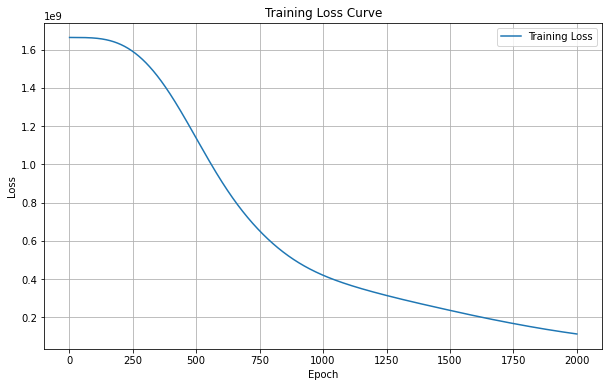

In [11]:

# Assuming X_tensor and y_tensor are already defined as PyTorch tensors
# Assuming model, criterion, and optimizer are already defined

num_epochs = 2000
batch_size = 32
losses = []

for epoch in range(num_epochs):
    # Shuffle and batch data (if desired)
    permutation = torch.randperm(X_tensor.size(0))
    for i in range(0, X_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_X, batch_y = X_tensor[indices], y_tensor[indices]

        # Forward pass
        outputs = model(batch_X)

        # Calculate loss
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Append the average loss for the epoch to the list
    losses.append(loss.item())

    # Print progress
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the loss curve
plt.figure(figsize=(10, 6), facecolor="white")
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Set model to evaluation mode (e.g., for dropout layers)
model.eval()

# Example: Make predictions (unseen data)
# Note: You should split your data into training and testing sets for proper evaluation

# Convert test data to PyTorch tensor and normalize (if needed)
# Then use model(X_test_tensor) to get predictions
X_test_np = X_test.values.astype(np.float32)
X_test_tensor = torch.tensor(X_test_np)
output_tensor = model(X_test_tensor)
output_tensor

tensor([[57443.5625],
        [51486.8125],
        [70782.3281],
        [89103.5156]], grad_fn=<AddmmBackward0>)

In [13]:
pred = pd.Series(output_tensor.detach().numpy().flatten(), name='Predicted Value')

In [14]:
y_test

Year
2020    35403.611111
2021    47424.583333
2022    75808.958333
2023    94537.500000
Name: Value, dtype: float64

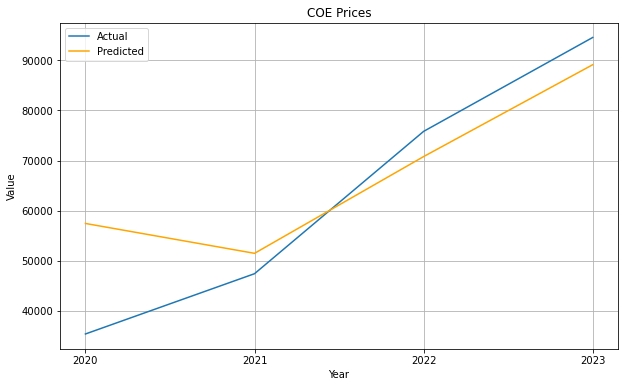

In [18]:
# Plot the loss curve
plt.figure(figsize=(10, 6), facecolor="white")
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, pred, label='Predicted', color="Orange")
plt.xlabel('Year')
plt.xticks(ticks=y_test.index)
plt.ylabel('Value')
plt.title('COE Prices')
plt.legend()
plt.grid(True)
plt.show()